# Advanced Computational Methods in Statistics
### Gerardo Durán-Martín

In [1]:
import jax
import blackjax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from functools import partial
from jax.scipy import stats
from jsl.lds.kalman_filter import LDS, filter

In [2]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [6]:
cblue = "#006AFF"
cblue_light = "#00CCFF"
cred = "#FF0D35"
corange_dark = "#FF4A21"
corange_light = "#FF8D0A"
cpink = "#FF26FF"
cgreen = "#29CC36"
cyellow = "#FADD00"
cpurple = "#9F19FF"
cbrown = "#994926"

In [7]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (8, 3)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[cblue, cgreen, cred, corange_light])
plt.rcParams["figure.facecolor"] = "w"

jnp.set_printoptions(precision=5, suppress=True)

We consider the following scalar linear Gaussian model

$$
\begin{aligned}
    X_n &= \rho X_{n-1} + \tau V_n\\
    Y_n &= X_n + \sigma W_n
\end{aligned}
$$
with

* $V_n, W_n \sim \mathcal{N}(0, 1)$
* $X_0 \sim \mathcal{N}(0, 1)$

In [8]:
@dataclass
class SSMConfig:
    rho: float
    tau: float
    sigma: float
    n_particles: int

n_particles = 500
ssm_config = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles)

In [9]:
def sample_step(x_prev, key, ssm):
    latent_noise, obs_noise = jax.random.normal(key, (2,))
    
    x_next = ssm.rho * x_prev + ssm.tau * latent_noise
    y_next = x_next + ssm.sigma * obs_noise
    
    state = {"x": x_next, "y": y_next}
    return x_next, state

In [10]:
num_timesteps  = 500
key = jax.random.PRNGKey(314)
key, key_init, *key_steps = jax.random.split(key, num_timesteps + 2)
key_steps = jnp.r_[key_steps]
key, key_sis, key_smc = jax.random.split(key, 3)

In [11]:
x_init = jax.random.normal(key_init)

sample_step_part = partial(sample_step, ssm=ssm_config)

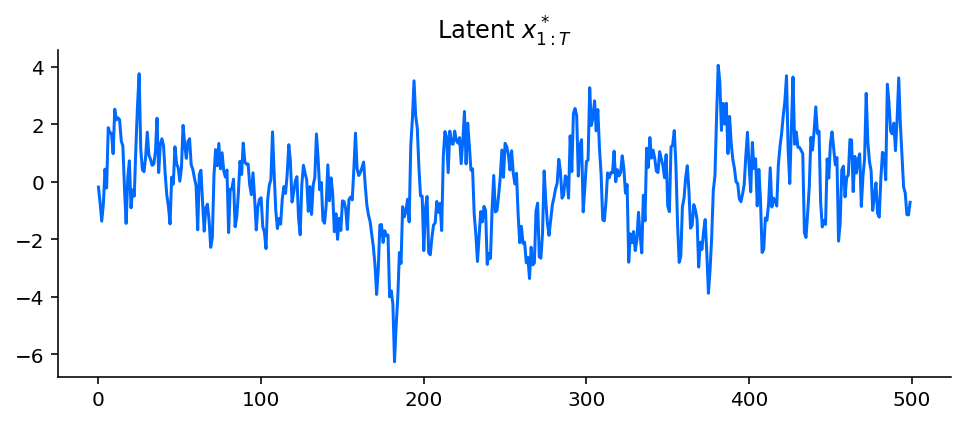

In [12]:
_, hist = jax.lax.scan(sample_step_part, x_init, key_steps)

y_obs = hist["y"]
x_latent = hist["x"]

fig, ax = plt.subplots()
ax.plot(x_latent)
ax.set_title("Latent $x^*_{1:T}$");

# Sequential Importance Sampling (IS)

In [13]:
def sis_step(state, xs, config):
    log_w_prev, x_prev = state
    key, y = xs
    
    x_next = config.rho * x_prev + jax.random.normal(key, (config.n_particles,)) * config.tau
    log_w_next = log_w_prev + stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next
    }
    
    return (log_w_next, x_next), carry


def sis_lssm(key, observations, ssm_config):
    """
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    keys_step = jax.random.split(key, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (log_w_init, x_init)
    input_vals = (keys_step, observations)
    
    sis_step_apply = partial(sis_step, config=ssm_config)
    _, res = jax.lax.scan(sis_step_apply, init_state, input_vals)
    
    weights = jnp.exp(res["log_weights"] - jax.nn.logsumexp(res["log_weights"], axis=1, keepdims=True))
    res["weights"] = weights
    
    return res

# Sequential Monte Carlo

In [14]:
def smc_step(state, xs, config):
    log_w_prev, x_prev = state
    key_resampling, key_proposal, y = xs
    
    # Resampling
    # x_prev= jax.random.choice(key_resampling, x_prev, shape=(config.n_particles,), p=jnp.exp(log_w_prev))
    x_prev_ix = jax.random.categorical(key_resampling, log_w_prev, shape=(config.n_particles,))
    x_prev = x_prev[x_prev_ix]
    
    x_next = config.rho * x_prev + jax.random.normal(key_proposal, (config.n_particles,)) * config.tau
    log_w_next = stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    w_next = jnp.exp(log_w_next - jax.nn.logsumexp(log_w_next))
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next,
        "weights": w_next,
    }
    
    return (log_w_next, x_next), carry


def smc_lssm(key, observations, ssm_config):
    """
    Sequential Monte-Carlo linear state-space-model
    
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    
    keys_resamp, keys_proposal = jax.random.split(keys_step)
    keys_resamp = jax.random.split(keys_resamp, num_timesteps)
    keys_proposal = jax.random.split(keys_proposal, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    w_init = jnp.exp(log_w_init)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (log_w_init, x_init)
    input_vals = (keys_resamp, keys_proposal, observations)
    
    smc_step_apply = partial(smc_step, config=ssm_config)
    _, res = jax.lax.scan(smc_step_apply, init_state, input_vals)
        
    return res

## Kalman filter

We perfom Kalman filter to compare against our estimated posteriors using particle filtering

In [15]:
lds = LDS(jnp.array([[ssm_config.rho]]), jnp.array([1.0]),
          jnp.array([[ssm_config.tau]]) ** 2, jnp.array([[ssm_config.sigma]]) ** 2,
          jnp.array([0.0]), jnp.array([[1.0]]))

expected_value_kf, covariance_kf, marg_mean, marg_var = filter(lds, y_obs[:, None])

expected_value_kf = expected_value_kf.ravel()
covariance_kf = covariance_kf.ravel()

marg_mean = marg_mean.ravel()
marg_var = marg_var.ravel()

## Estimating expected value

In [16]:
# Sequential importance sampling
sis_res = sis_lssm(key_sis, y_obs, ssm_config)
expected_value_sis = jnp.einsum("tn,tn->t", sis_res["particles"], sis_res["weights"])

In [17]:
# Sequential Monte Carlo
smc_res = smc_lssm(key_smc, y_obs, ssm_config)
expected_value_smc = jnp.einsum("tn,tn->t", smc_res["particles"], smc_res["weights"]).block_until_ready()

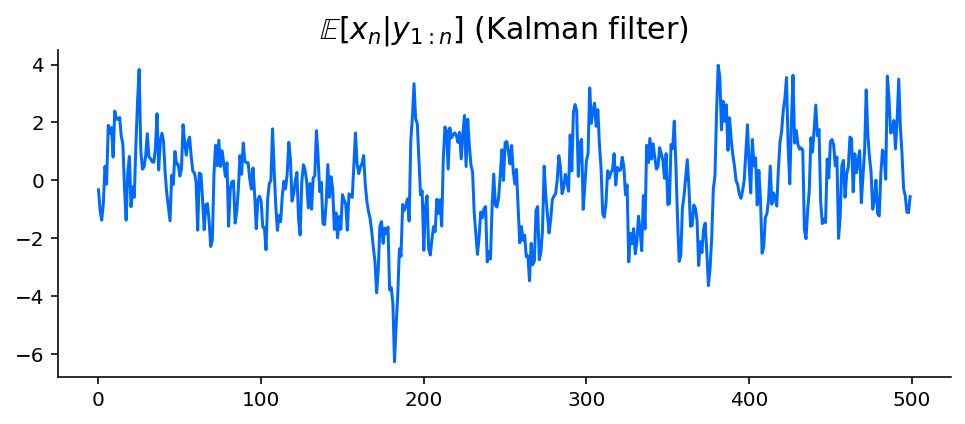

In [18]:
plt.plot(expected_value_kf, label="SIS")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (Kalman filter)", fontsize=15);

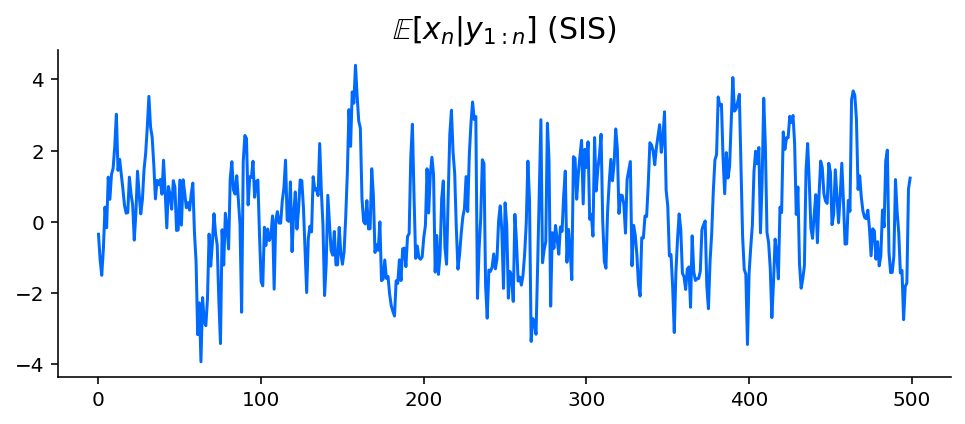

In [19]:
plt.plot(expected_value_sis, label="SIS")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (SIS)", fontsize=15);

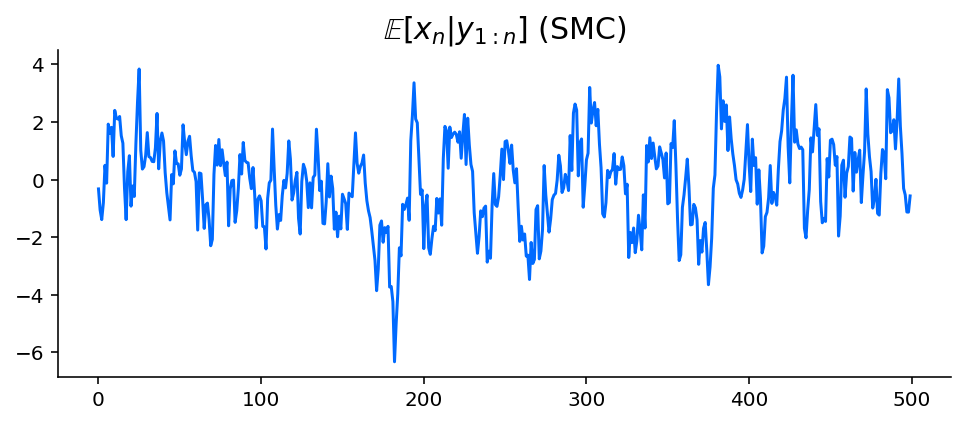

In [20]:
plt.plot(expected_value_smc, label="Particle filter (SMC)")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (SMC)", fontsize=15);

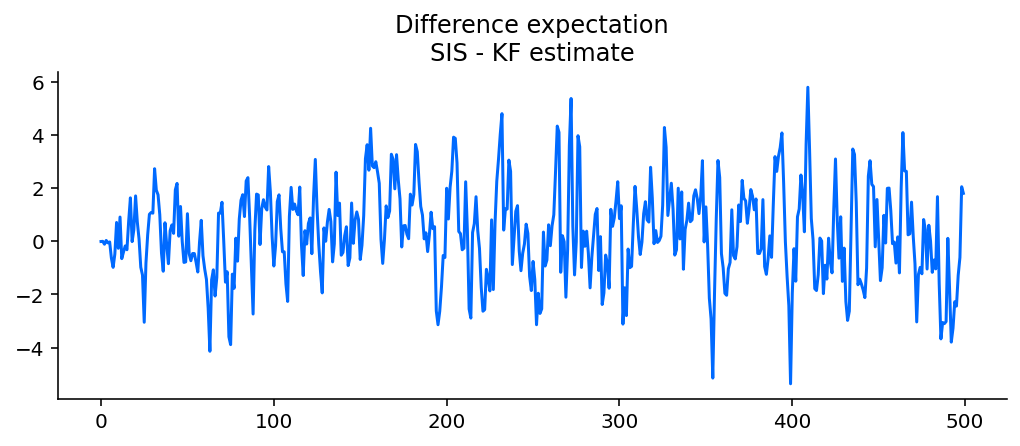

In [21]:
fig, ax = plt.subplots(figsize=(8.5, 3))
plt.plot(expected_value_sis - expected_value_kf)
plt.title("Difference expectation\nSIS - KF estimate");

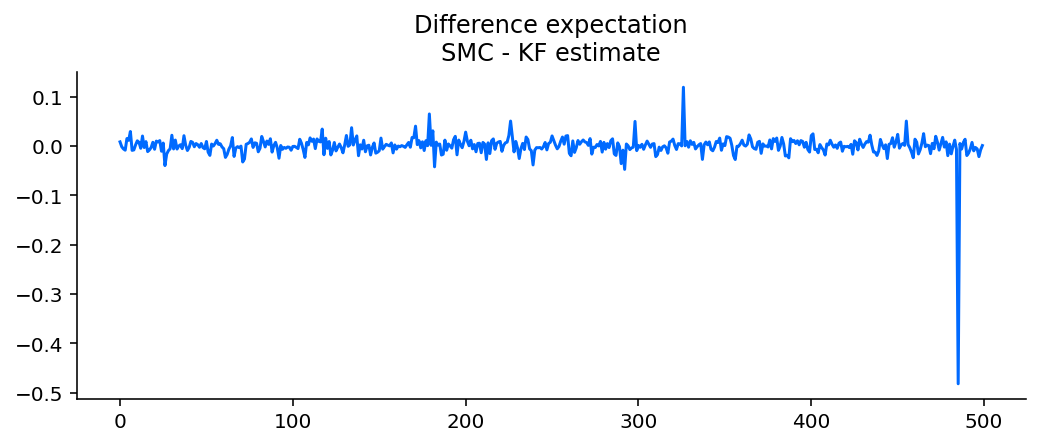

In [22]:
fig, ax = plt.subplots(figsize=(8.5, 3))
plt.plot(expected_value_smc - expected_value_kf)
plt.title("Difference expectation\nSMC - KF estimate");

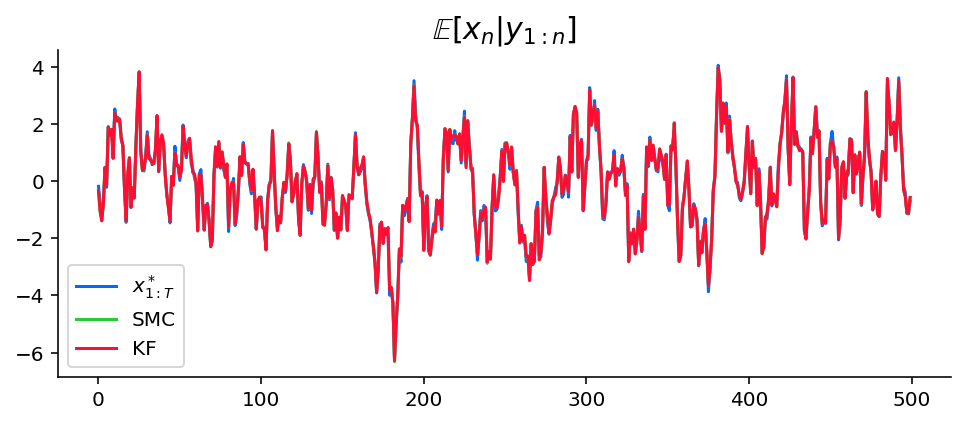

In [23]:
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$", fontsize=15);
plt.plot(x_latent, label="$x^*_{1:T}$")
plt.plot(expected_value_smc, label="SMC")
plt.plot(expected_value_kf, label="KF")
plt.legend()

## Estimating second-order moment $\mathbb{E}[X^2_t \vert Y_{0:t}]$

In [24]:
expected_value_squared_smc = jnp.einsum("tn,tn->t", smc_res["particles"] ** 2, smc_res["weights"]).block_until_ready()
expected_value_squared_kf = covariance_kf + expected_value_kf ** 2

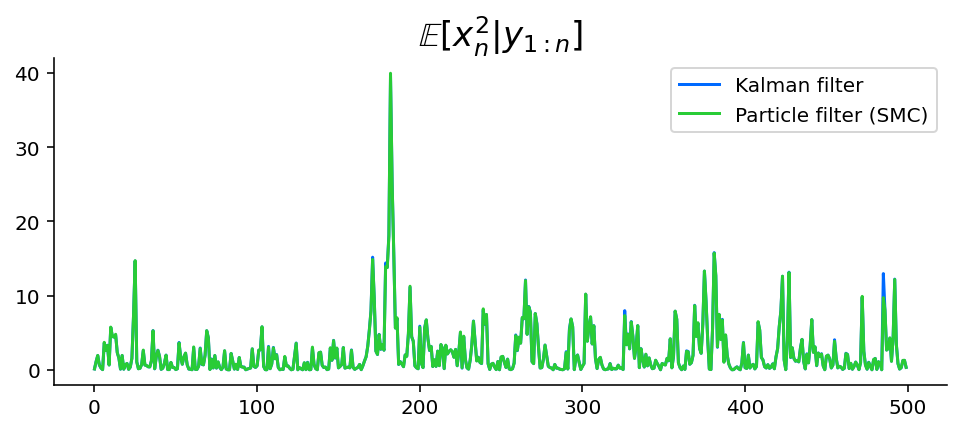

In [25]:
plt.plot(expected_value_squared_kf, label="Kalman filter")
plt.plot(expected_value_squared_smc, label="Particle filter (SMC)")
plt.legend()
plt.title(r"$\mathbb{E}[x_n^2 \vert y_{1:n}]$", fontsize=17);

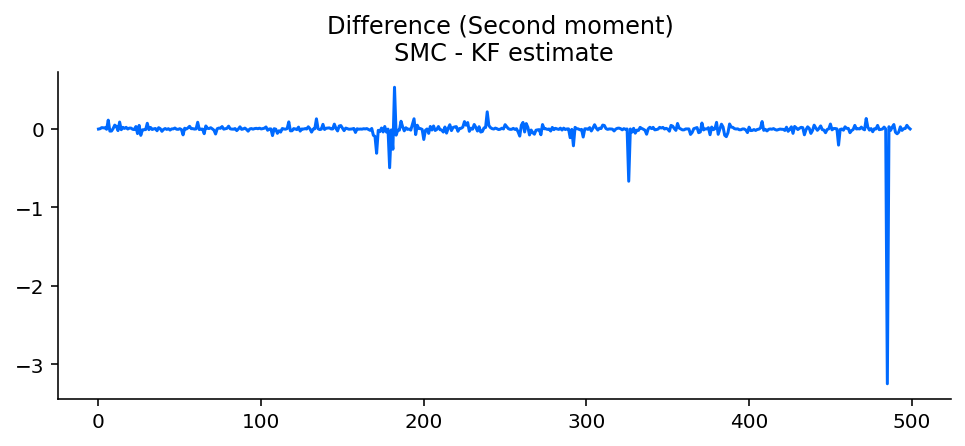

In [26]:
plt.plot(expected_value_squared_smc - expected_value_squared_kf)
plt.title("Difference (Second moment) \nSMC - KF estimate");

## Computing marginal probablity

$$
\begin{aligned}
p(y_{1:t}) &= \int p(y_{1:t}, x_t) dx_t\\
           &= \int p(y_t, y_{1:t-1}, x_t) dx_t
\end{aligned}
$$

In [27]:
ssm_bigger = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles * 10)
ssm_smaller = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles // 10)

smc_bigger = smc_lssm(key_smc, y_obs, ssm_bigger)
smc_smaller = smc_lssm(key_smc, y_obs, ssm_smaller)

In [28]:
marginal_ll_pf = jnp.log(jnp.exp(smc_res["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_pf_bigger = jnp.log(jnp.exp(smc_bigger["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_pf_smaller = jnp.log(jnp.exp(smc_smaller["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_kf = stats.norm.logpdf(y_obs, marg_mean, jnp.sqrt(marg_var + ssm_config.sigma ** 2)).cumsum()

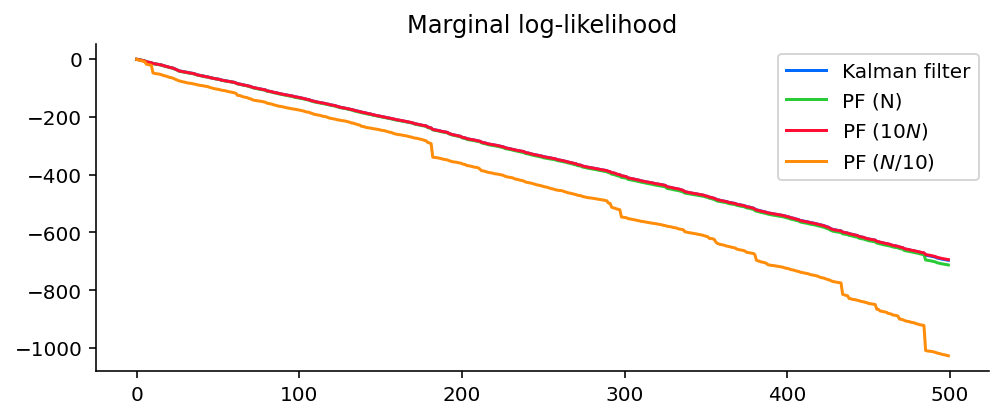

In [29]:
plt.plot(marginal_ll_kf, label="Kalman filter")
plt.plot(marginal_ll_pf, label="PF (N)")
plt.plot(marginal_ll_pf_bigger, label="PF ($10N$)")
plt.plot(marginal_ll_pf_smaller, label="PF ($N/10$)")
plt.title("Marginal log-likelihood")
plt.legend();

# Question 2

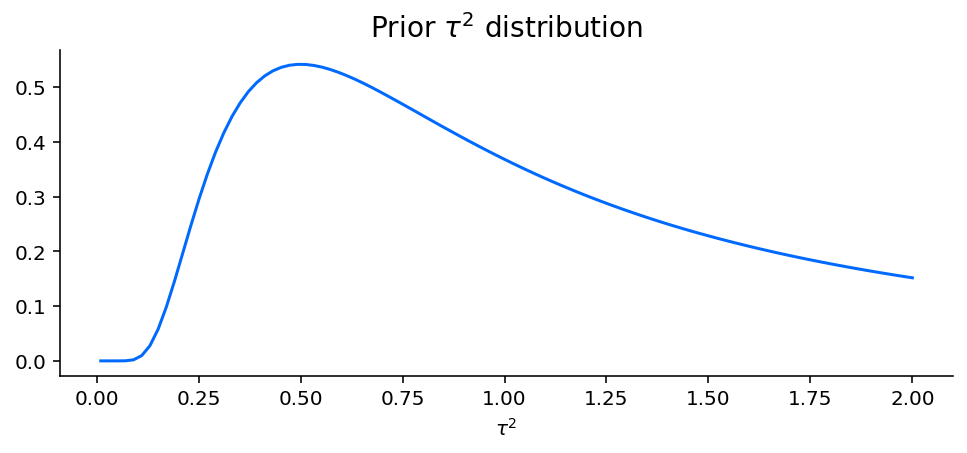

In [30]:
tau2_range = jnp.linspace(0.01, 2, 100)
tau2_prior_pdf = tfd.InverseGamma(1.0, 1.0).prob(tau2_range)
plt.plot(tau2_range, tau2_prior_pdf)
plt.title(r"Prior $\tau^2$ distribution", fontsize=14)
plt.xlabel(r"$\tau^2$");

## Ideal marginal Metropolis-Hastings


$$
    p(\tau^2) = \text{InvGamma}(\tau^2 | 1, 1) =(1 / \tau^2) ^ 2 \exp(-1/\tau^2)
$$

So that

$$
    \log p(\tau^2) = -2 \log(\tau^2) - 1 / \tau^2
$$

In [31]:
key, key_init, key_sample = jax.random.split(key, 3)

In [32]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


In [33]:
def logprob_fn(w):
    """
    The log-probability density function of the posterior distribution of the model.
    """
    rho, logtau2 = w
    tau2 = jnp.exp(logtau2)
    
    lds = LDS(jnp.array([[rho]]), jnp.array([1.0]),
              jnp.array([[tau2]]), jnp.array([[ssm_config.sigma]]) ** 2,
              jnp.array([0.0]), jnp.array([[1.0]]))
    *_, marg_mean, marg_var = filter(lds, y_obs[:, None])
    
    marginal_ll_kf = stats.norm.logpdf(y_obs, marg_mean.ravel(), jnp.sqrt(marg_var.ravel() + ssm_config.sigma ** 2)).sum()
    log_prior_tau2 = -2 * logtau2 - 1 / tau2
    
    ll = marginal_ll_kf + log_prior_tau2 + jnp.log(1/2)

    return ll


In [34]:
w0 = jax.random.multivariate_normal(key_init, 0.1 + jnp.zeros(2), jnp.eye(2))
rmh = blackjax.rmh(logprob_fn, sigma=jnp.ones(2) * 0.08)
initial_state = rmh.init(w0)

In [35]:
burnin = 1000
num_steps = 25_000
states = inference_loop(key_sample, rmh.step, initial_state, num_steps)

xrange = jnp.arange(burnin, num_steps)
rho_trace, logtau2_trace = states.position[burnin:, :].T
tau2_trace = jnp.exp(logtau2_trace)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [36]:
# Expected posterior for τ^2
tau2_trace.mean()

DeviceArray(0.9308, dtype=float32)

In [37]:
# Expected posterior for ρ
rho_trace.mean()

DeviceArray(0.77432, dtype=float32)

In [38]:
def plot_autocorrelation(series, lag_max):
    lags = jnp.arange(1, lag_max)
    autocorr = jnp.array([jnp.corrcoef(series[:-lag], series[lag:])[1,0] for lag in lags])
    autocorr = jnp.insert(autocorr, 0, 1)

    for lag, corr in zip(lags, autocorr):
        plt.scatter(lag, corr, c=cblue)
        corr = corr.item()
        plt.axvline(x=lag, ymin=0, ymax=corr, linewidth=2)
    return autocorr

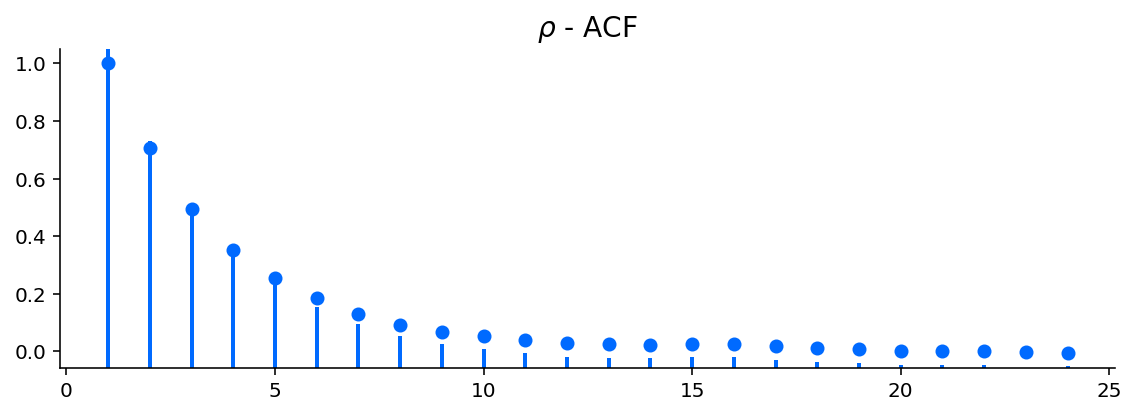

In [39]:
plot_autocorrelation(rho_trace, 25)
plt.title(r"$\rho$ - ACF", fontsize=14);
plt.tight_layout()

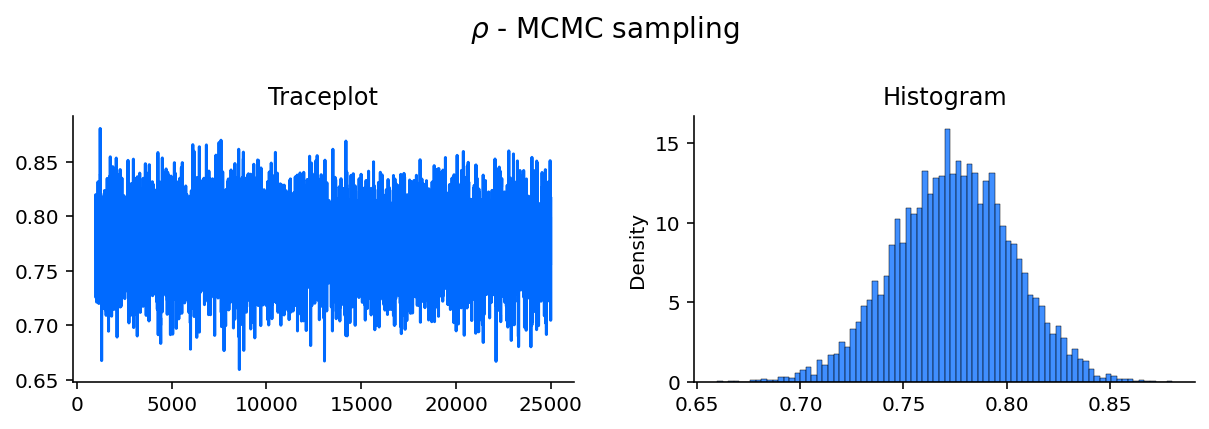

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3))
ax[0].plot(xrange, rho_trace)
sns.histplot(rho_trace, ax=ax[1], stat="density")
ax[0].set_title("Traceplot")
ax[1].set_title("Histogram")
plt.suptitle(r"$\rho$ - MCMC sampling", fontsize=14)
plt.tight_layout()

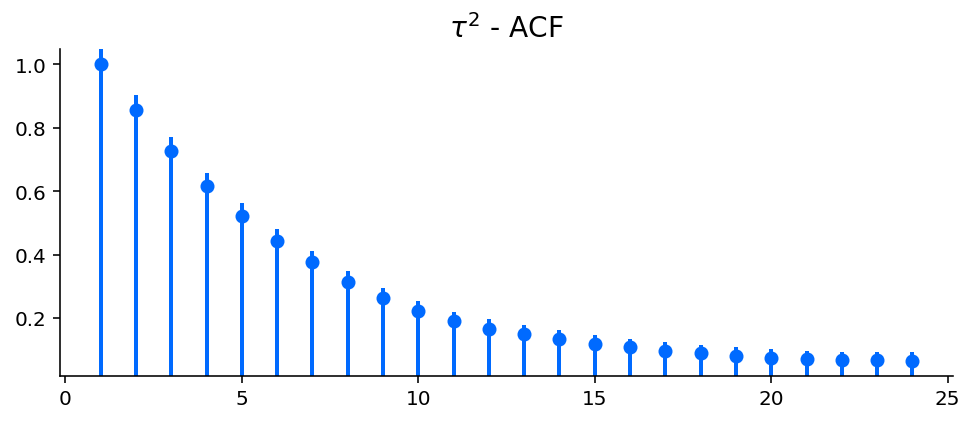

In [41]:
plot_autocorrelation(tau2_trace, 25)
plt.title(r"$\tau^2$ - ACF", fontsize=14);

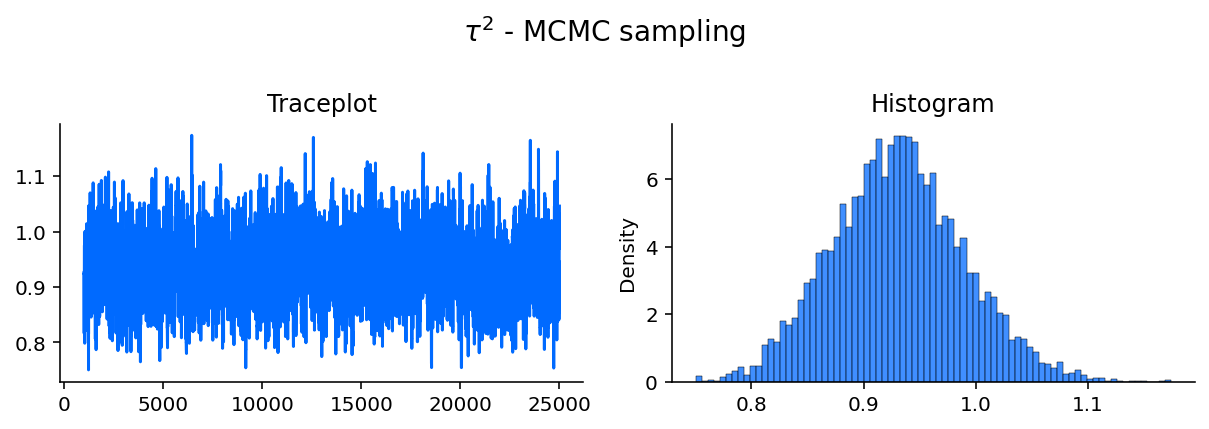

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3))
ax[0].plot(xrange, tau2_trace)
sns.histplot(tau2_trace, ax=ax[1], stat="density")
ax[0].set_title("Traceplot")
ax[1].set_title("Histogram")
plt.suptitle(r"$\tau^2$ - MCMC sampling", fontsize=14)
plt.tight_layout()

## Particle Marginal Metropolis Hastings (PMMH)

In [220]:
key, key_pmmh_init, key_pmmh = jax.random.split(key, 3)

In [221]:
def compute_marginal_log_likelihood(smc_res):
    log_weights = smc_res["log_weights"]
    _, N = log_weights.shape
    # marginal_ll = jnp.log(jnp.exp(log_weights).mean(axis=1)).sum()
    marginal_ll = jax.nn.logsumexp(log_weights, b=1/N, axis=1).sum()
    return marginal_ll

In [348]:
%%time
key_smc, key_params = jax.random.split(key_pmmh_init, 2)

n_particles = 100
sigma_proposal = 0.1
theta_prev = jax.random.multivariate_normal(key_params, jnp.zeros(2) + 1.0, jnp.eye(2) * sigma_proposal)
theta_prev = jnp.clip(theta_prev, -1, 1)
rho_samp, log_tau2_samp = theta_prev
tau2_samp = jnp.exp(log_tau2_samp)

# rho_samp = jax.random.uniform(key_rho) * 2 - 1
# log_tau2_samp = jax.random.normal(key_tau) * sigma_proposal
# tau2_samp = jnp.exp(log_tau2_samp)

# ssm_config = SSMConfig(rho=rho_samp, tau=jnp.sqrt(tau2_samp), sigma=0.1, n_particles=n_particles)
ssm_config = SSMConfig(rho=rho_samp, tau=1.0, sigma=0.1, n_particles=n_particles)
smc_res = smc_lssm(key_smc, y_obs, ssm_config)
marginal_ll_prev = compute_marginal_log_likelihood(smc_res)
marginal_ll_prev = marginal_ll_prev + logprob_fn_pmmh(theta_prev)
marginal_ll_prev.block_until_ready()

CPU times: user 746 ms, sys: 16.1 ms, total: 763 ms
Wall time: 610 ms


DeviceArray(-841.4357, dtype=float32)

### Transition state

In [601]:
def pmmh_step(state, key, n_particles, discount, step_update, prop_min=None):
    """
    Particle marginal metropolis-hastings (PMMH)
    """
    theta_prev, marginal_ll_prev, sigma_proposal, it = state
    key_params, key_smc, key_transition = jax.random.split(key, 3)
    # sigma_proposal = jax.lax.cond(it % step_update == 0,
    #                              lambda: sigma_proposal * (1 - discount),
    #                              lambda: sigma_proposal)
    sigma_proposal = sigma_proposal * (1 - discount / step_update)
    sigma_proposal = jnp.clip(sigma_proposal, a_min=prop_min)
    
    # sample from proposal
    theta_proposal = theta_prev + sigma_proposal * jax.random.normal(key_params, (2,))
    rho_proposal, log_tau2_proposal = theta_proposal
    rho_proposal = jnp.clip(rho_proposal, -1, 1)
    tau_proposal = jnp.sqrt(jnp.exp(log_tau2_proposal))

    
    # Run SMC and estimate marginal log-likelihood from proposal
    ssm_proposal_config = SSMConfig(rho=rho_proposal, tau=tau_proposal,
                                    sigma=0.1, n_particles=n_particles)
    
    smc_proposal_res = smc_lssm(key_smc, y_obs, ssm_proposal_config)
    marginal_ll_proposal = compute_marginal_log_likelihood(smc_proposal_res)
    marginal_ll_proposal = marginal_ll_proposal + logprob_fn_pmmh(theta_proposal)
    
    # Compute transition probability
    pr_transition = marginal_ll_proposal - marginal_ll_prev
    pr_transition = jnp.clip(jnp.exp(pr_transition), 0.0, 1.0)
    
    # Choose next sample from proposal
    # is_accept = jax.random.uniform(key_transition) >= pr_transition
    is_accept = jax.random.bernoulli(key_transition, pr_transition)
    theta_next, marginal_ll_next = jax.lax.cond(is_accept,
                                                lambda: (theta_proposal, marginal_ll_proposal),
                                                lambda: (theta_prev, marginal_ll_prev))
    
    carry = {
        "params": theta_next,
        "mll": marginal_ll_next,
        "sigma_proposal": sigma_proposal,
        "pr": marginal_ll_proposal - marginal_ll_prev
    }
    
    return (theta_next, marginal_ll_next, sigma_proposal, it+1), carry

In [ ]:
sigma_proposal = 0.1
n_particles = 1000
lenght_chain = 25_000

state_init = theta_prev, marginal_ll_prev, sigma_proposal, 1
keys = jax.random.split(key_pmmh, lenght_chain)
pmmh_step_apply = partial(pmmh_step,
                          n_particles=n_particles, discount=0.3,
                          step_update=300, prop_min=0.001)

# 0.3, 100, 0.001
init_time = time()
_, pmmh_res = jax.lax.scan(pmmh_step_apply, state_init, keys)
mll_hist = pmmh_res["mll"].block_until_ready()
end_time = time()

running_time = end_time - init_time
print(f"Running time: {running_time:0.2f}s")

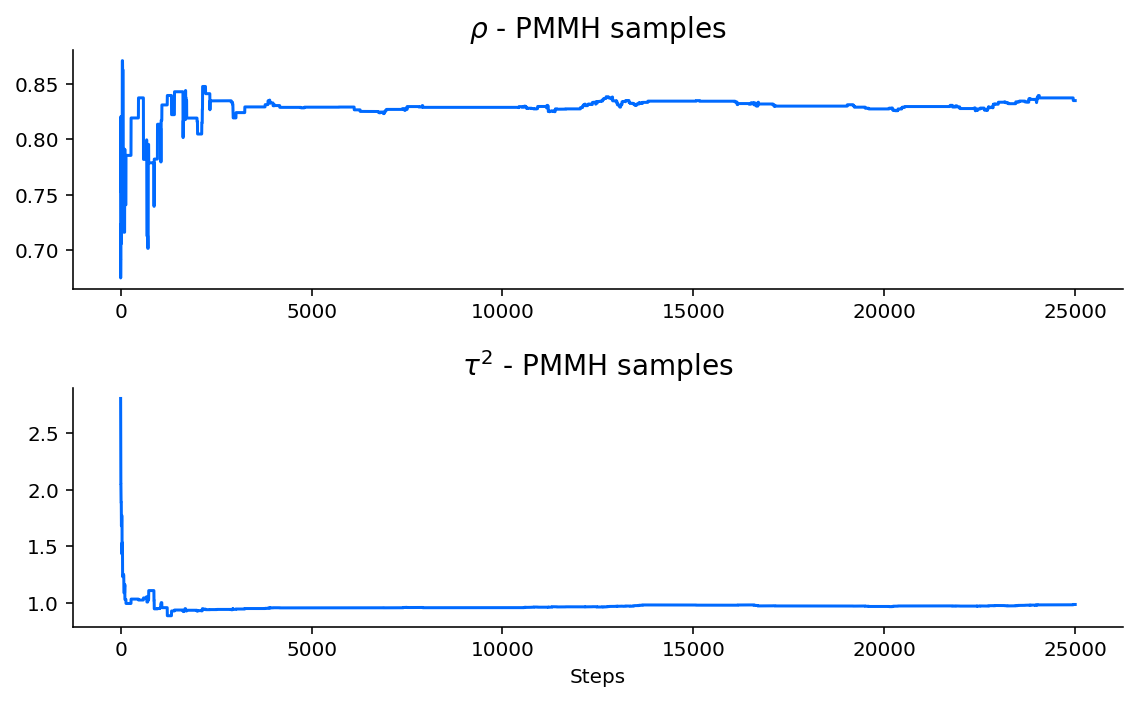

In [715]:
burnin = 10_000
xrange = jnp.arange(burnin, lenght_chain)

rho_pmmh_trace  = pmmh_res["params"][:, 0]
tau2_pmmh_trace = jnp.exp(pmmh_res["params"][:, 1])

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(rho_pmmh_trace)
ax[1].plot(tau2_pmmh_trace)

ax[0].set_title(r"$\rho$ - PMMH samples", fontsize=14)
ax[1].set_title(r"$\tau^2$ - PMMH samples", fontsize=14)
ax[1].set_xlabel("Steps")
plt.tight_layout()

Text(0, 0.5, 'MH proposal scale')

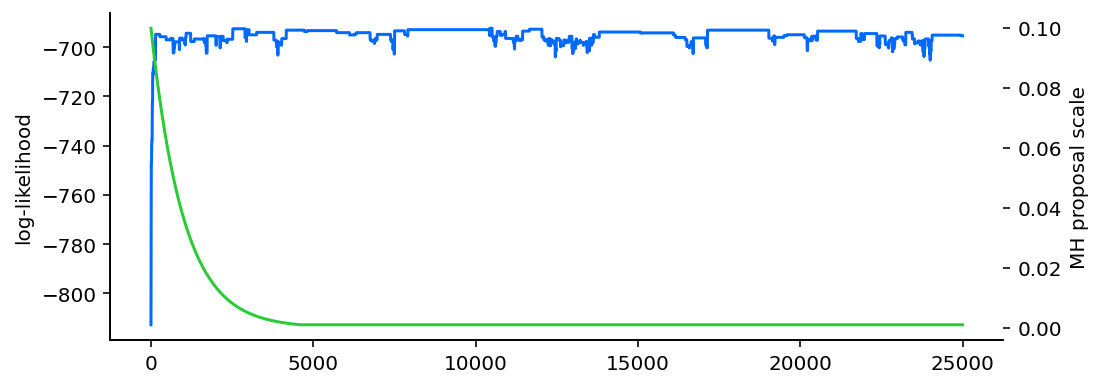

In [716]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(mll_hist)
ax2.plot(pmmh_res["sigma_proposal"], c=cgreen)
ax.set_ylabel("log-likelihood")
ax2.set_ylabel("MH proposal scale")

## ...

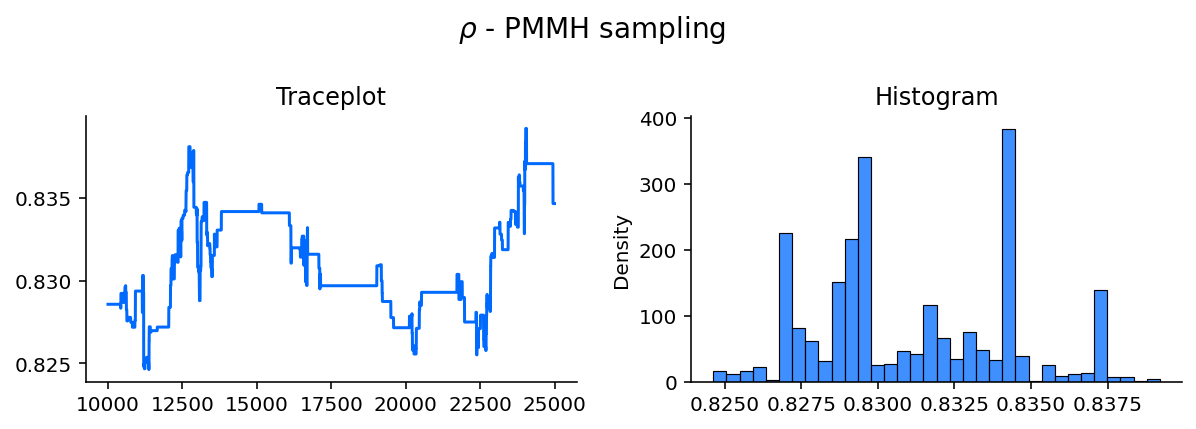

In [717]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3))
ax[0].plot(xrange, rho_pmmh_trace[burnin:])
sns.histplot(rho_pmmh_trace[burnin:], ax=ax[1], stat="density")
ax[0].set_title("Traceplot")
ax[1].set_title("Histogram")
plt.suptitle(r"$\rho$ - PMMH sampling", fontsize=14)
plt.tight_layout()

(0.0, 1.1)

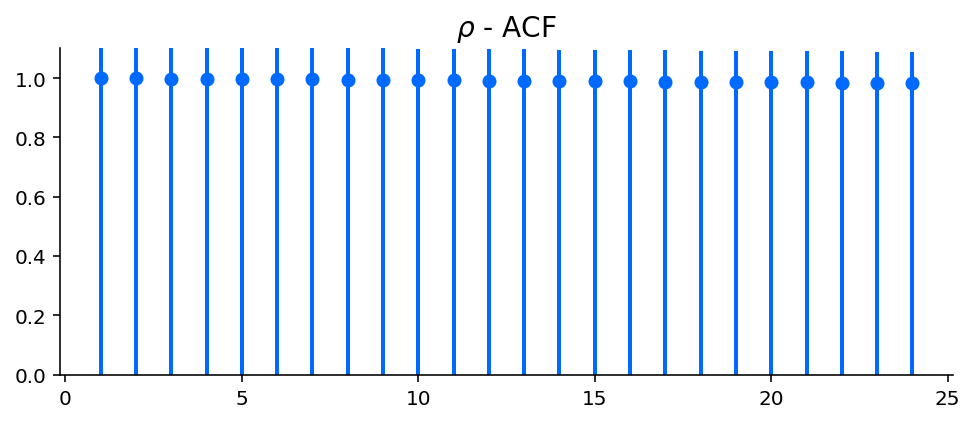

In [718]:
plot_autocorrelation(rho_pmmh_trace[burnin:], 25)
plt.title(r"$\rho$ - ACF", fontsize=14);
plt.ylim(0, 1.1)

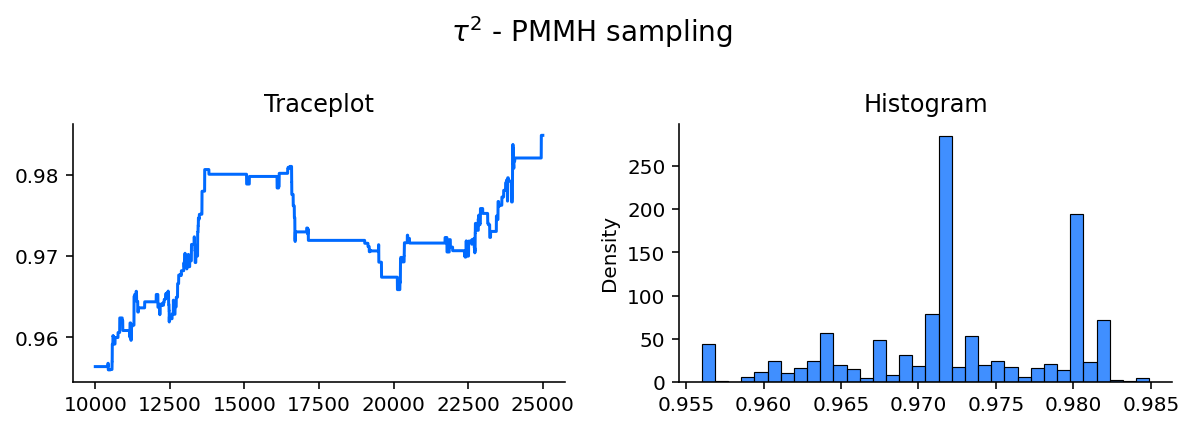

In [719]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3))
ax[0].plot(xrange, tau2_pmmh_trace[burnin:])
sns.histplot(tau2_pmmh_trace[burnin:], ax=ax[1], stat="density")
ax[0].set_title("Traceplot")
ax[1].set_title("Histogram")
plt.suptitle(r"$\tau^2$ - PMMH sampling", fontsize=14)
plt.tight_layout()

(0.0, 1.1)

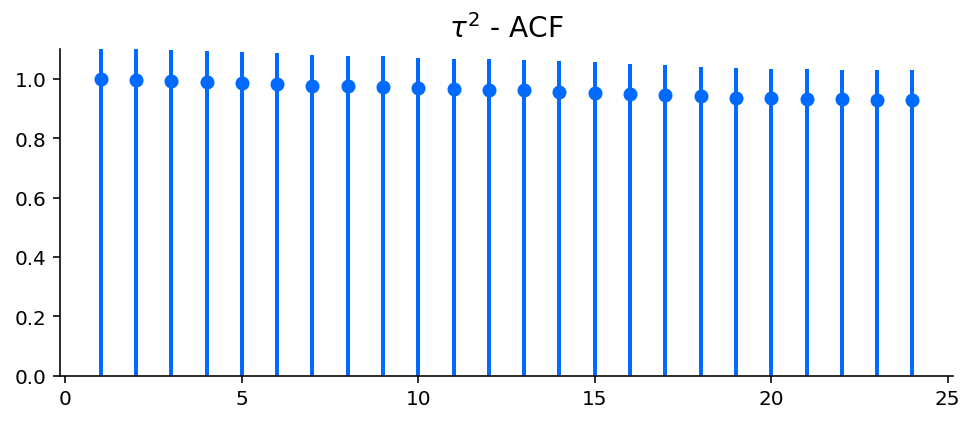

In [709]:
plot_autocorrelation(tau2_pmmh_trace[burnin:], 25)
plt.title(r"$\tau^2$ - ACF", fontsize=14);
plt.ylim(0, 1.1)